In [1]:
import abc

In [2]:
import numpy as np

In [3]:
np.seterr(all='raise', under='warn')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

---

activation function

In [4]:
class ActivationFunction(abc.ABC):
    def __init__(self):
        pass
    
    @property
    @abc.abstractmethod
    def derivative_use_activated(self):
        pass
    
    @abc.abstractmethod
    def apply(self, v):
        pass
    
    @abc.abstractmethod
    def derivative(self, v):
        pass

In [5]:
class ActivationNone(ActivationFunction):
    def __init__(self):
        pass
    
    @property
    def derivative_use_activated(self):
        return True
    
    def apply(self, v):
        return v
    
    def derivative(self, v):
        return 1

In [6]:
class ActivationSigmoid(ActivationFunction):
    def __init__(self, x_upper_bound=None, x_lower_bound=None):
        self.x_upper_bound = x_upper_bound
        self.x_lower_bound = x_lower_bound
    
    @property
    def derivative_use_activated(self):
        return True
    
    def apply(self, v):
        if self.x_upper_bound or self.x_upper_bound:
            return 1.0 / (1.0 + np.exp(-v.clip(max=self.x_upper_bound, min=self.x_lower_bound)))
        return 1.0 / (1.0 + np.exp(-v))
    
    def derivative(self, v):
        return v * (1 - v)

In [7]:
class ActivationRelu(ActivationFunction):
    def __init__(self):
        pass
    
    @property
    def derivative_use_activated(self):
        return True
    
    def apply(self, v):
        return v.clip(min=0)
    
    def derivative(self, v):
        return np.where(v>0,1,0)

---

gd optimizer

In [31]:
class GDOptimizer(abc.ABC):
    def __init__(self):
        self.weight_infos = {}
        self.intercept_infos = {}
    
    def register_layer(self, layer_id, weight_shape, intercept_shape):
        self.weight_infos[layer_id] = np.zeros(weight_shape)
        self.intercept_infos[layer_id] = np.zeros(intercept_shape)
    
    @abc.abstractmethod
    def apply(self, layer_id, grads, intercept_grads):
        pass

In [32]:
class GDOptimizerNone(GDOptimizer):
    def __init__(self, learning_rate):
        GDOptimizer.__init__(self)
        self.learning_rate = learning_rate
    
    def apply(self, layer_id, grads, intercept_grads):
        return self.learning_rate * grads, self.learning_rate * intercept_grads

In [33]:
class GDOptimizerMomentum(GDOptimizer):
    def __init__(self, learning_rate, gamma=0.9):
        GDOptimizer.__init__(self)
        self.learning_rate = learning_rate
        self.gamma = gamma
    
    def apply(self, layer_id, grads, intercept_grads):
        # In Momentum,
        # weight_infos and intercept_infos stores weight deltas calculated last time
        self.weight_infos[layer_id] = self.gamma*self.weight_infos[layer_id] + self.learning_rate*grads
        self.intercept_infos[layer_id] = self.gamma*self.intercept_infos[layer_id] + self.learning_rate*intercept_grads
        return self.weight_infos[layer_id], self.intercept_infos[layer_id]

In [34]:
class GDOptimizerAdagrad(GDOptimizer):
    def __init__(self, learning_rate=0.01, epsilon=1e-8):
        GDOptimizer.__init__(self)
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
        

In [35]:
class GDOptimizerAdadelta(GDOptimizer):
    def __init__(self, gamma=0.9, epsilon=1e-8):
        GDOptimizer.__init__(self)
        self.gamma = gamma
        self.epsilon = epsilon
        
        

In [196]:
# TODO: Problems here, got a large error in the end and maybe not converged
class GDOptimizerRMSprop(GDOptimizer):
    def __init__(self, learning_rate=0.001, gamma=0.9, epsilon=1e-8):
        GDOptimizer.__init__(self)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        
    def apply(self, layer_id, grads, intercept_grads):
        # In RMSprop,
        # weight_infos and intercept_infos stores E[g^2] calculated last time
        self.weight_infos[layer_id] = self.gamma*self.weight_infos[layer_id] \
            + (1-self.gamma)*np.power(grads,2)
        self.intercept_infos[layer_id] = self.gamma*self.intercept_infos[layer_id] \
            + (1-self.gamma)*np.power(intercept_grads,2)
        weight_delta = self.learning_rate * grads / np.sqrt(self.weight_infos[layer_id] + self.epsilon)
        intercept_delta = self.learning_rate * intercept_grads / np.sqrt(self.intercept_infos[layer_id] + self.epsilon)
        return weight_delta, intercept_delta

---

nn model

In [42]:
class NNLayer:
    def __init__(self, node_count, has_intercepts, activation):
        self.layer_id = None
        self.node_count = node_count
        self.has_intercepts = has_intercepts
        self.activation = activation
        self.weights = None
        self.intercepts = None
        self.weight_grads = None
        self.intercept_grads = None
        self.step_input = None
        self.reduced_sum = None
        self.step_output = None
    
    def init(self, layer_id, prev_node_count, gd_optimizer):
        self.layer_id = layer_id
        self.gd_optimizer = gd_optimizer
        self.weights, self.intercepts = self.xavier_weight_init(prev_node_count, self.node_count, self.has_intercepts)
        self.gd_optimizer.register_layer(self.layer_id, self.weights.shape, self.intercepts.shape)
    
    def forward(self, step_input):
        self.step_input = step_input
        self.reduced_sum = np.dot(self.step_input, self.weights)+self.intercepts
        self.step_output = self.activation.apply(self.reduced_sum)
        return self.step_output
    
    def back_propagation(self, prev_delta, activation_derivatived=False):
        cur_delta = None
        if activation_derivatived:
            cur_delta = prev_delta
        elif self.activation.derivative_use_activated:
            cur_delta = prev_delta * self.activation.derivative(self.step_output)
        else:
            cur_delta = prev_delta * self.activation.derivative(self.reduced_sum)
        self.weight_grads = np.dot(np.atleast_2d(self.step_input).T, cur_delta)/cur_delta.shape[0]
        self.intercept_grads = cur_delta.mean(axis=0)
        return np.dot(cur_delta, self.weights.T)
    
    def update_weights(self):
        weight_deltas, intercept_deltas = \
            self.gd_optimizer.apply(self.layer_id, self.weight_grads, self.intercept_grads)
        self.weights -= weight_deltas
        if self.has_intercepts:
            self.intercepts -= intercept_deltas
    
    def drop_out(self):
        self.weights = np.zeros(self.weights.shape)
        self.intercepts = np.zeros(self.intercepts.shape)
        self.step_output = np.zeros(self.step_output.shape)
    
    def xavier_weight_init(self, prev_node_count, cur_node_count, has_intercepts):
        weights = np.random.randn(prev_node_count, cur_node_count)/np.sqrt(prev_node_count)
        intercepts = np.random.randn(cur_node_count)/np.sqrt(prev_node_count) \
            if has_intercepts else np.zeros(cur_node_count)
        return weights, intercepts

In [43]:
class NNModel:
    def __init__(self, X_size, layers, gd_optimizer):
        self.X_size = X_size
        self.model = layers
        self.gd_optimizer = gd_optimizer
        self.init_model()
    
    # initialize model with layers
    def init_model(self):
        prev_node_count = self.X_size
        for layer_no, layer in enumerate(self.model):
            layer.init(layer_no, prev_node_count, self.gd_optimizer)
            prev_node_count = layer.node_count
    
    # forward pass, calculate predict value with current model (batch or single)
    def model_forward(self, X):
        cur_res = X
        for layer in self.model:
            cur_res = layer.forward(cur_res)
        return cur_res
    
    # update model with errs (y_predict - y) by back propagation
    def update_model(self, y_predict, y):
        delta = np.atleast_2d(y_predict - y)
        for layer in reversed(self.model):
            delta = layer.back_propagation(delta, activation_derivatived=(layer==self.model[-1]))
        for layer in self.model:
            layer.update_weights()

---

test

In [17]:
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn import metrics

In [18]:
test_data = sklearn.datasets.load_breast_cancer(return_X_y=False)

In [19]:
test_data_x_org = test_data['data']
test_data_y_org = test_data['target']

In [20]:
test_data_x_org.shape

(569, 30)

In [21]:
test_data_std = (test_data_x_org - np.mean(test_data_x_org, axis=0)) / np.std(test_data_x_org, axis=0)

In [22]:
test_data_x = test_data_std[:500]
test_data_y = test_data_y_org[:500]

In [175]:
learning_rate = 0.05

In [186]:
rounds = 200

In [187]:
batch_size = 1

In [197]:
layers = [
    NNLayer(20, True, ActivationSigmoid(x_upper_bound=500, x_lower_bound=-500)),
    NNLayer(10, True, ActivationSigmoid(x_upper_bound=500, x_lower_bound=-500)),
    NNLayer(1, True, ActivationSigmoid(x_upper_bound=500, x_lower_bound=-500)),
]

In [198]:
m = NNModel(test_data_x.shape[1], layers, GDOptimizerRMSprop(learning_rate=0.0005))

In [199]:
%%time
all_cost = []
all_cost_ce = []
for _ in range(rounds):
    cost = 0
    cost_ce = 0
    learning_idx = np.arange(len(test_data_x))
    np.random.shuffle(learning_idx)
    
    for start_idx in range(0, len(test_data_x), batch_size):
        data_idx = learning_idx[start_idx : min(start_idx+batch_size,len(test_data_x))]
#         data_idx = learning_idx[start_idx]
        sample, target = test_data_x[data_idx], test_data_y[data_idx,None]
        predict = m.model_forward(sample)
        m.update_model(predict, target)
        err = predict - target
        cost += (err*err).sum()
        cost_ce -= (target*np.log(predict)+(1-target)*np.log(1-predict)).sum()
    all_cost.append(cost)
    all_cost_ce.append(cost_ce)

Wall time: 31.3 s


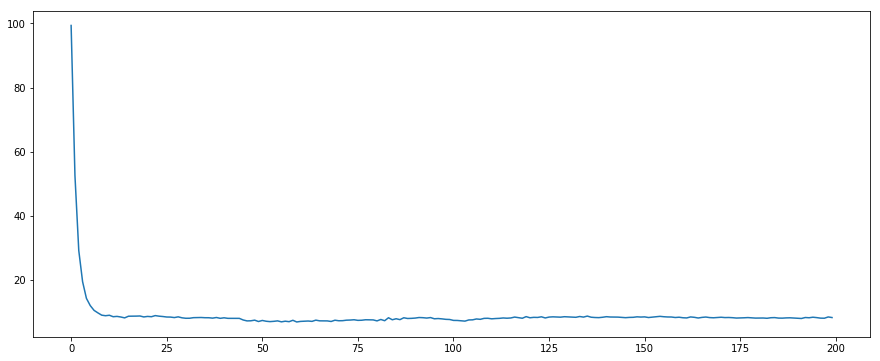

In [200]:
plt.figure(figsize=(15,6))
plt.plot(all_cost)

In [201]:
predict_data_x = test_data_std[500:]
predict_data_y = test_data_y_org[500:]

In [202]:
predict_y = []
for sample, tgt in zip(predict_data_x, predict_data_y):
    pct = m.model_forward(sample)
    predict_y.append(pct)

In [203]:
metrics.confusion_matrix(predict_data_y, [1 if pct > 0.5 else 0 for pct in predict_y])

array([[17,  0],
       [ 4, 48]], dtype=int64)

In [204]:
all_cost[-1]

8.376945909369782